In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [2]:
raw_df = pd.read_csv('data/zillow_data.csv')

Filter only for Texas
<br>Drop Metro becasue there were many nulls, and it was redundant with other location data 
<br> Drop regionID and SizeRank because values were specific to Zillow 

In [3]:
raw_df = raw_df[raw_df['State']=='TX']

In [4]:
raw_df.drop(['RegionID','Metro','State','SizeRank'],axis=1, inplace=True)


In [5]:
raw_df

,RegionName,City,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,75070,McKinney,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,79936,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,77084,Houston,Harris,95000.0,95200.0,95400.0,95700.0,95900.0,96100.0,96200.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,77449,Katy,Harris,95400.0,95600.0,95800.0,96100.0,96400.0,96700.0,96800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,76941,Mertzon,Irion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,122500,121800,121600,122200,123500,124700,124300,122600,121600,121600
14472,79313,Anton,Hockley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55400,56300,55700,56300,58900,61500,63000,63600,63500,63300
14492,79355,Plains,Yoakum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100500,100500,101000,100700,99700,97700,95800,94600,94000,93500
14599,79366,Ransom Canyon,Lubbock,134500.0,134500.0,134400.0,134400.0,134300.0,134200.0,134200.0,...,252100,251600,251600,251500,251300,251500,251700,252500,255000,257500


In [6]:
def melt_data(raw_df):
    melted = pd.melt(raw_df, id_vars=['RegionName', 'City', 'CountyName'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
df = melt_data(raw_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   RegionName  255096 non-null  int64         
 1   City        255096 non-null  object        
 2   CountyName  255096 non-null  object        
 3   date        255096 non-null  datetime64[ns]
 4   value       255096 non-null  float64       
 5   year        255096 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 13.6+ MB


In [8]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,RegionName,City,CountyName,value,year
date,,,,,
1996-04-01,75070,McKinney,Collin,235700.0,1996
1996-04-01,77494,Katy,Harris,210400.0,1996
1996-04-01,79936,El Paso,El Paso,77300.0,1996
1996-04-01,77084,Houston,Harris,95000.0,1996
1996-04-01,77449,Katy,Harris,95400.0,1996
...,...,...,...,...,...
2018-04-01,76941,Mertzon,Irion,121600.0,2018
2018-04-01,79313,Anton,Hockley,63300.0,2018
2018-04-01,79355,Plains,Yoakum,93500.0,2018


# EDA

Create DataFrame to perform stationarity checks and transformations

In [9]:
df_prices = pd.DataFrame(df['value'], index = df.index)
df_prices

,value
date,
1996-04-01,235700.0
1996-04-01,210400.0
1996-04-01,77300.0
1996-04-01,95000.0
1996-04-01,95400.0
...,...
2018-04-01,121600.0
2018-04-01,63300.0
2018-04-01,93500.0


**Mean prices by year**

<AxesSubplot:xlabel='date'>

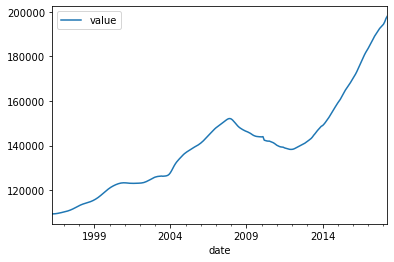

In [10]:
avg_prices = df_prices.groupby('date').aggregate({'value':'mean'})
avg_prices.plot()

<AxesSubplot:xlabel='date'>

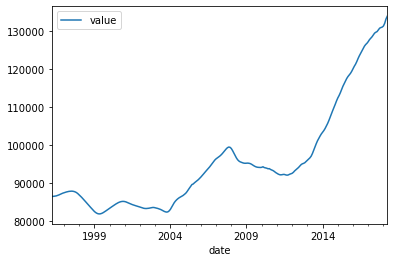

In [11]:
std_prices = df_prices.groupby('date').aggregate({'value':'std'})
std_prices.plot()

<AxesSubplot:xlabel='date'>

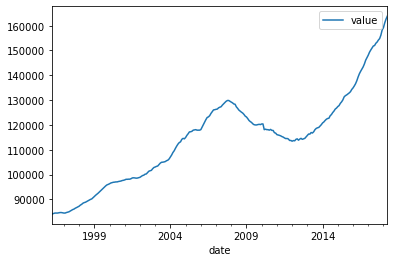

In [12]:
med_prices = df_prices.groupby('date').aggregate({'value':'median'})
med_prices.plot()

In [ ]:
std_zipcodes = df.groupby(['RegionName','year']).aggregate({'value':'std'}).sort_values



In [ ]:
std_zipcodes.plot() 

In [14]:
zipcodes = []
for zipcode in df['RegionName']:
    if zipcode not in zipcodes:
        zipcodes.append(zipcode)
zipcodes = sorted(zipcodes) 
zipcodes

[75001,
 75002,
 75006,
 75007,
 75009,
 75010,
 75013,
 75019,
 75022,
 75023,
 75024,
 75025,
 75028,
 75032,
 75033,
 75034,
 75035,
 75038,
 75039,
 75040,
 75041,
 75042,
 75043,
 75044,
 75048,
 75050,
 75051,
 75052,
 75056,
 75057,
 75060,
 75061,
 75062,
 75063,
 75065,
 75067,
 75068,
 75069,
 75070,
 75071,
 75074,
 75075,
 75077,
 75078,
 75080,
 75081,
 75082,
 75087,
 75088,
 75089,
 75093,
 75094,
 75098,
 75103,
 75104,
 75109,
 75110,
 75115,
 75116,
 75117,
 75119,
 75124,
 75126,
 75134,
 75135,
 75137,
 75140,
 75141,
 75143,
 75144,
 75146,
 75148,
 75149,
 75150,
 75154,
 75156,
 75159,
 75160,
 75163,
 75165,
 75166,
 75167,
 75169,
 75173,
 75180,
 75181,
 75182,
 75189,
 75201,
 75204,
 75205,
 75206,
 75209,
 75210,
 75211,
 75214,
 75217,
 75218,
 75219,
 75220,
 75224,
 75225,
 75227,
 75228,
 75229,
 75230,
 75231,
 75232,
 75233,
 75234,
 75235,
 75236,
 75237,
 75238,
 75241,
 75243,
 75244,
 75248,
 75249,
 75252,
 75253,
 75254,
 75287,
 75402,
 75407,


In [15]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

In [16]:
# results = stationarity_check(df_prices)
# results

Log Transformations 

In [17]:
df_log = np.log(df_prices)
fig = plt.figure(figsize=(12,6))


<Figure size 864x432 with 0 Axes>

In [ ]:
plt.plot(df_log, color='blue');

df_wrm = df['value'].ewm(halflife=2).mean()
df_minus_wrm = df - df_wrm
df_minus_wrm.plot(figsize=(15,8))
